# Final Project Parts 4-7 Analysis

## Imports

In [1]:
from astropy.io import fits
import lmfit
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from scipy.signal import find_peaks, medfilt
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.colors import LogNorm
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.ndimage import median_filter
from collections import defaultdict

from astropy import units as u
from specutils import Spectrum, SpectralRegion
from specutils.analysis import equivalent_width, fwhm

from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d

from scipy.ndimage import center_of_mass, shift
from photutils.centroids import centroid_2dg

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
%matplotlib widget  

## Functions

In [2]:
def collect_fits_files(directory):
    # containers
    rc_files = []
    reduced_files = []
    ref1_files = []
    ref2_files = []
    ref3_files = []
    toi_files = []
    full_files = []

    for fname in os.listdir(directory):
        if not fname.endswith(".fits"):
            continue

        # strip extension
        base = fname[:-5]

        if base.endswith("_rc"):
            rc_files.append(fname)
        elif base.endswith("_reduced"):
            reduced_files.append(fname)
        elif base.endswith("_ref1"):
            ref1_files.append(fname)
        elif base.endswith("_ref2"):
            ref2_files.append(fname)
        elif base.endswith("_ref3"):
            ref3_files.append(fname)
        elif base.endswith("_toi"):
            toi_files.append(fname)
        else:
            # no suffix → full / raw fits
            full_files.append(fname)

    # sort everything for consistency
    for lst in [rc_files, reduced_files, ref1_files, ref2_files, ref3_files, toi_files, full_files]:
        lst.sort()

    return {
        "rc": rc_files,
        "reduced": reduced_files,
        "ref1": ref1_files,
        "ref2": ref2_files,
        "ref3": ref3_files,
        "toi": toi_files,
        "full": full_files,
    }

def identify_target_from_filename(fname, target_centers):
    for key in target_centers:
        if f"_{key}.fits" in fname:
            return key
    return None

def crop_image(data, x0, y0, half_size=20):
    """
    Return an EXACT (2*half_size)x(2*half_size) crop centered on (x0,y0).
    If the crop would go out of bounds, it pads with NaNs so the output is still 40x40.
    """
    ny, nx = data.shape
    size = 2 * half_size

    x0 = int(round(x0))
    y0 = int(round(y0))

    # desired bounds in the original image
    x1 = x0 - half_size
    x2 = x0 + half_size
    y1 = y0 - half_size
    y2 = y0 + half_size

    # overlap with actual image bounds
    ox1 = max(0, x1)
    ox2 = min(nx, x2)
    oy1 = max(0, y1)
    oy2 = min(ny, y2)

    cut = data[oy1:oy2, ox1:ox2]

    # pad into a fixed-size array
    out = np.full((size, size), np.nan, dtype=data.dtype if np.issubdtype(data.dtype, np.floating) else float)

    # where the overlap lands in the output array
    px1 = ox1 - x1
    px2 = px1 + (ox2 - ox1)
    py1 = oy1 - y1
    py2 = py1 + (oy2 - oy1)

    out[py1:py2, px1:px2] = cut
    return out

def recenter_cutout_around_centroid(img, size=20, method="2dg"):
    """
    Find the centroid of a star in a small image and return a new
    size x size cutout centered on that centroid.

    Parameters
    ----------
    img : 2D ndarray
        Input cutout image containing a star.
    size : int
        Output cutout size in pixels (size x size). Prefer even sizes like 20.
    method : {"2dg", "com"}
        Centroiding method:
          - "2dg": photutils centroid_2dg (recommended)
          - "com": center of mass (fallback)

    Returns
    -------
    new_cutout : 2D ndarray
        Recentered cutout (size x size). If near an edge, the function pads with zeros.
    (xc, yc) : tuple of floats
        Centroid coordinates in the original input `img` coordinate system (x, y).
    """
    img = np.asarray(img)
    ny, nx = img.shape

    # Replace NaNs with median for centroiding stability
    if np.any(~np.isfinite(img)):
        med = np.nanmedian(img)
        img_cent = np.where(np.isfinite(img), img, med)
    else:
        img_cent = img

    # --- centroid estimate ---
    if method == "2dg":
        xc, yc = centroid_2dg(img_cent)
    elif method == "com":
        # center-of-mass fallback
        y, x = np.indices(img_cent.shape)
        w = img_cent - np.min(img_cent)
        w = np.clip(w, 0, None)
        tot = np.sum(w)
        if tot == 0:
            xc, yc = (nx - 1) / 2, (ny - 1) / 2
        else:
            xc = np.sum(x * w) / tot
            yc = np.sum(y * w) / tot
    else:
        raise ValueError("method must be '2dg' or 'com'")

    # --- build the new cutout around the centroid ---
    half = size // 2
    x0 = int(np.round(xc))
    y0 = int(np.round(yc))

    x1, x2 = x0 - half, x0 + half
    y1, y2 = y0 - half, y0 + half

    # Create output and paste overlapping region
    new_cutout = np.zeros((size, size), dtype=img.dtype)

    src_x1 = max(0, x1)
    src_x2 = min(nx, x2)
    src_y1 = max(0, y1)
    src_y2 = min(ny, y2)

    dst_x1 = src_x1 - x1
    dst_x2 = dst_x1 + (src_x2 - src_x1)
    dst_y1 = src_y1 - y1
    dst_y2 = dst_y1 + (src_y2 - src_y1)

    new_cutout[dst_y1:dst_y2, dst_x1:dst_x2] = img[src_y1:src_y2, src_x1:src_x2]

    return new_cutout, (xc, yc)

def find_brightest_pixel(data, r=1):
    """
    Find brightest pixel using small circular apertures and return its (x,y) coordinates.
    """
    ny, nx = data.shape

    # Create apertures centered on every pixel
    y, x = np.mgrid[0:ny, 0:nx]
    positions = np.column_stack((x.ravel(), y.ravel()))

    apertures = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(data, apertures)

    # Find brightest aperture
    fluxes = phot_table['aperture_sum']
    idx_max = np.argmax(fluxes)

    x0, y0 = positions[idx_max]
    return int(x0), int(y0)

def gaussian2d(coords, amp, x0, y0, sx, sy, offset):
    x, y = coords
    g = amp * np.exp(-(((x - x0)**2) / (2*sx**2) + ((y - y0)**2) / (2*sy**2))) + offset
    return g.ravel()

def get_fwhm(frame_index, fnames, fit_halfsize=8):
    data = fits.getdata(fnames[frame_index])

    ny, nx = data.shape

    # initial center = brightest pixel
    y_peak, x_peak = np.unravel_index(np.argmax(data), data.shape)

    # cut a small box around peak
    x1 = max(0, x_peak - fit_halfsize)
    x2 = min(nx, x_peak + fit_halfsize + 1)
    y1 = max(0, y_peak - fit_halfsize)
    y2 = min(ny, y_peak + fit_halfsize + 1)

    sub = data[y1:y2, x1:x2]

    # coordinate grids in *full-image* coordinates
    yy = np.arange(y1, y2)
    xx = np.arange(x1, x2)
    X, Y = np.meshgrid(xx, yy)

    # initial guesses
    offset0 = np.median(sub)
    amp0 = np.max(sub) - offset0
    x0_0 = x_peak
    y0_0 = y_peak
    sx0 = sy0 = 2.5

    p0 = [amp0, x0_0, y0_0, sx0, sy0, offset0]

    # bounds: amp>0, center within subbox, sigmas reasonable
    lower = [0, x1, y1, 0.5, 0.5, -np.inf]
    upper = [np.inf, x2, y2, 20.0, 20.0, np.inf]

    popt, pcov = curve_fit(
        gaussian2d, (X, Y), sub.ravel(),
        p0=p0, bounds=(lower, upper),
        maxfev=20000
    )

    amp, x0_fit, y0_fit, sx_fit, sy_fit, offset_fit = popt

    fwhm_x = 2 * np.sqrt(2 * np.log(2)) * sx_fit
    fwhm_y = 2 * np.sqrt(2 * np.log(2)) * sy_fit

    return x0_fit, y0_fit, sx_fit, sy_fit, fwhm_x, fwhm_y

def calculate_fwhm_stats(fwhm_list):
    fwhm_xs = np.array([fwhm[0] for fwhm in fwhm_list])
    fwhm_ys = np.array([fwhm[1] for fwhm in fwhm_list])

    mean_x = np.mean(fwhm_xs)
    std_x = np.std(fwhm_xs)

    mean_y = np.mean(fwhm_ys)
    std_y = np.std(fwhm_ys)

    mask = (np.abs(fwhm_xs - mean_x) > 1 * std_x) | (np.abs(fwhm_ys - mean_y) > 1 * std_y)

    return mean_x, std_x, mean_y, std_y, mask


## Filepaths

In [3]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'kaia_data')

fits_files = collect_fits_files(data_dir)
rc_fnames = fits_files['rc']
reduced_fnames = fits_files['reduced']
full_fnames = fits_files['full']
toi_fnames = fits_files['toi']
ref1_fnames = fits_files['ref1']
ref2_fnames = fits_files['ref2']
ref3_fnames = fits_files['ref3']

## Part 3) Derive and Check Instrumental Magnitudes

In [4]:
# just assume an ideal aperture size for now and update later
ideal_apertures_size = 8.75

In [5]:
# centers of each target, in the rc frame
target_centers = {
    "toi": (755+10, 755+10),
    "ref1": (765+10, 825+10),
    "ref2": (136, 990),
    "ref3": (930+10, 255+10),
}

In [6]:
# re-crop files to make sure never cut off
crop_dir = os.path.join(data_dir, "rc_crops_40x40")
os.makedirs(crop_dir, exist_ok=True)

half_size = 20  

for fname in rc_fnames:
    fpath = os.path.join(data_dir, fname)

    with fits.open(fpath) as hdul:
        data = hdul[0].data
        hdr = hdul[0].header

    base = fname[:-5]  # strip ".fits" (e.g., TOI-2046b_g_..._rc)

    for target, (x0, y0) in target_centers.items():
        crop = crop_image(data, x0, y0, half_size=half_size)

        # update header so the crop is self-describing
        new_hdr = hdr.copy()
        new_hdr["CROPX0"] = (x0, "Crop center X (pixel, in rc frame)")
        new_hdr["CROPY0"] = (y0, "Crop center Y (pixel, in rc frame)")
        new_hdr["HALFSZ"] = (half_size, "Half-size of crop in pixels")
        new_hdr["SRCFILE"] = (fname, "Source rc filename")

        outname = f"{base}_{target}.fits"
        outpath = os.path.join(crop_dir, outname)

        fits.writeto(outpath, crop, header=new_hdr, overwrite=True)

print(f"Done. Wrote crops to: {crop_dir}")

Done. Wrote crops to: /Users/adeutsch/Desktop/UVA/25-fall/observational/final/kaia_data/rc_crops_40x40


In [7]:
# get new fits files
crop_fits_files = collect_fits_files(crop_dir)
crop_ref1_fnames = crop_fits_files['ref1']
crop_ref2_fnames = crop_fits_files['ref2']
crop_ref3_fnames = crop_fits_files['ref3']
crop_toi_fnames = crop_fits_files['toi']

Ok so after re-doing the crop, ref2 is giving me problems. So for now I am just going to use the original ref2 files, and use the re-cropped files for toi, ref1 and ref3. Just make sure to remember that ref2 is *20x20* while toi, ref1, and ref3 are *40x40*

In [8]:
# get final paths for toi and refs
ref1_fnames_final = []
ref2_fnames_final = []
ref3_fnames_final = []
toi_fnames_final = []

for i in range(len(crop_toi_fnames)):
    ref1_fnames_final.append(os.path.join(crop_dir, crop_ref1_fnames[i]))
    ref2_fnames_final.append(os.path.join(data_dir, ref2_fnames[i]))
    ref3_fnames_final.append(os.path.join(crop_dir, crop_ref3_fnames[i]))
    toi_fnames_final.append(os.path.join(crop_dir, crop_toi_fnames[i]))

In [9]:
# for each frame use photutils aperture_photometry to find brightest pixel and assign that as the center
(x0, y0) = find_brightest_pixel(fits.getdata(ref1_fnames_final[0]), r=1)
print(f"Ref1 initial brightest pixel at: x={x0}, y={y0}")

Ref1 initial brightest pixel at: x=13, y=11


In [10]:
ref1_ap_centers = []
ref2_ap_centers = []
ref3_ap_centers = []
toi_ap_centers = []

for i in range(len(toi_fnames_final)):
    # ref1
    (x0, y0) = find_brightest_pixel(fits.getdata(ref1_fnames_final[i]), r=1)
    ref1_ap_centers.append((x0, y0))

    # ref2
    (x0, y0) = find_brightest_pixel(fits.getdata(ref2_fnames_final[i]), r=1)
    ref2_ap_centers.append((x0, y0))

    # ref3
    (x0, y0) = find_brightest_pixel(fits.getdata(ref3_fnames_final[i]), r=1)
    ref3_ap_centers.append((x0, y0))

    # toi
    (x0, y0) = find_brightest_pixel(fits.getdata(toi_fnames_final[i]), r=1)
    toi_ap_centers.append((x0, y0))

In [11]:
# for each frame index, use the header to get the mjd time and store it in a list
mjds = []
for i in range(len(toi_fnames_final)):
    with fits.open(toi_fnames_final[i]) as hdul:
        hdr = hdul[0].header
        mjd = hdr.get("JD-OBS", None) - 2400000.5
        mjds.append(mjd)

In [12]:
# get the fwhms for each frame
ref1_fwhms = []
ref2_fwhms = []
ref3_fwhms = []
toi_fwhms = []

for i in range(len(toi_fnames_final)):
    # ref1
    (x0_fit, y0_fit, _, _, fwhm_x, fwhm_y) = get_fwhm(i, ref1_fnames_final)
    ref1_fwhms.append((fwhm_x, fwhm_y))
    ref1_ap_centers[i] = (x0_fit, y0_fit)

    # ref2
    (x0_fit, y0_fit, _, _, fwhm_x, fwhm_y) = get_fwhm(i, ref2_fnames_final)
    ref2_fwhms.append((fwhm_x, fwhm_y))
    ref2_ap_centers[i] = (x0_fit, y0_fit)

    # ref3
    (x0_fit, y0_fit, _, _, fwhm_x, fwhm_y) = get_fwhm(i, ref3_fnames_final)
    ref3_fwhms.append((fwhm_x, fwhm_y))
    ref3_ap_centers[i] = (x0_fit, y0_fit)

    # toi
    (x0_fit, y0_fit, _, _, fwhm_x, fwhm_y) = get_fwhm(i, toi_fnames_final)
    toi_fwhms.append((fwhm_x, fwhm_y))
    toi_ap_centers[i] = (x0_fit, y0_fit)

# calculate the mean fwhm_x and fwhm_y for each target, and make a mask to flag frames where fwhm_x or fwhm_y is more than 3 sigma away from the mean
ref1_stats = calculate_fwhm_stats(ref1_fwhms)
ref2_stats = calculate_fwhm_stats(ref2_fwhms)
ref3_stats = calculate_fwhm_stats(ref3_fwhms)
toi_stats = calculate_fwhm_stats(toi_fwhms)

mask = ~(ref1_stats[4] | ref2_stats[4] | ref3_stats[4] | toi_stats[4])

ref1_fnames_final = np.array(ref1_fnames_final)[mask]
ref2_fnames_final = np.array(ref2_fnames_final)[mask]
ref3_fnames_final = np.array(ref3_fnames_final)[mask]
toi_fnames_final = np.array(toi_fnames_final)[mask]

ref1_ap_centers = np.array(ref1_ap_centers)[mask]
ref2_ap_centers = np.array(ref2_ap_centers)[mask]
ref3_ap_centers = np.array(ref3_ap_centers)[mask]
toi_ap_centers = np.array(toi_ap_centers)[mask]

ref1_fwhms = np.array(ref1_fwhms)[mask]
ref2_fwhms = np.array(ref2_fwhms)[mask]
ref3_fwhms = np.array(ref3_fwhms)[mask]
toi_fwhms = np.array(toi_fwhms)[mask]

mjds = np.array(mjds)[mask]

(60979.171554199886, 60979.38201279985)

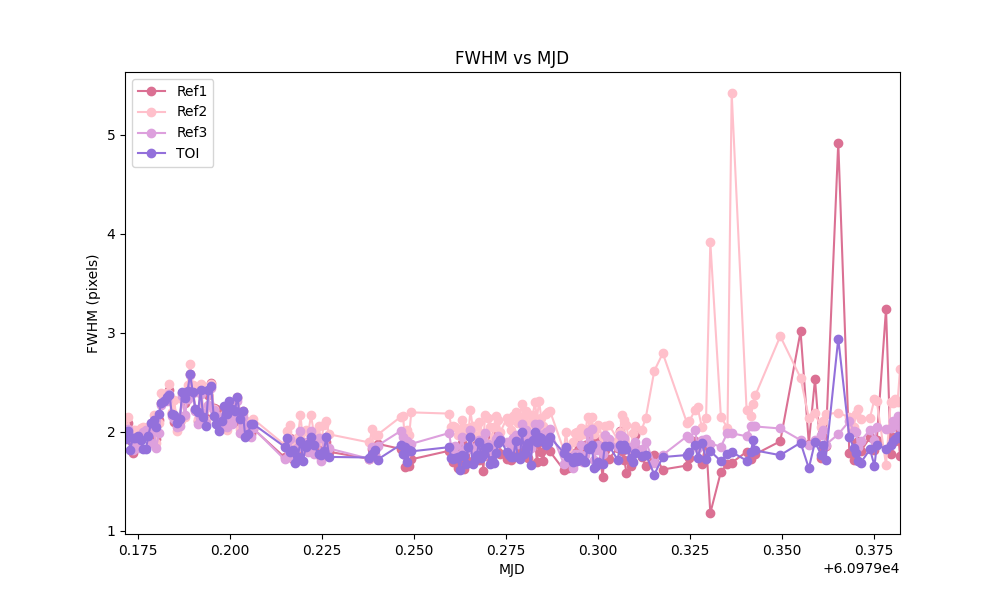

In [13]:
# plot fwhm_x vs mjd for each target for the first half of the frames
colors = ["palevioletred", "pink", "plum", "mediumpurple"]
names = ["Ref1", "Ref2", "Ref3", "TOI"]
fwhm_files = [ref1_fwhms, ref2_fwhms, ref3_fwhms, toi_fwhms]
plt.figure(figsize=(10, 6))
for i, fwhms in enumerate(fwhm_files):
    fwhm_xs = [fwhm[0] for fwhm in fwhms]
    plt.plot(mjds, fwhm_xs, marker='o', linestyle='-', color=colors[i], label=f"{names[i]}")
plt.xlabel('MJD')
plt.ylabel('FWHM (pixels)')
plt.title('FWHM vs MJD')
plt.legend()
plt.xlim(mjds[0], mjds[-1])

So it seems like we are expected to just accept the assertion that the ratio between ideal aperture size and source FWHM is constant across all frames. Ideally I would like to verify this assertion by calculating the ideal aperture size at EVERY frame and calculating the ratio of aperture size to FWHM, but that is outside the scope of this project.

In [14]:
# determine ratio of ideal aperture size to mean fwhm_x

# pick a representative frame and get the mean of the fwhms for each target in that frame
index = 6
fwhm_mean = (((ref1_fwhms[index][0] + ref2_fwhms[index][0] + ref3_fwhms[index][0] + toi_fwhms[index][0]) / 4.0) + 
             ((ref1_fwhms[index][1] + ref2_fwhms[index][1] + ref3_fwhms[index][1] + toi_fwhms[index][1]) / 4.0)) / 2.0
ideal_ratio = ideal_apertures_size / fwhm_mean
print(f"Ideal aperture size to mean FWHM ratio: {ideal_ratio:.3f}")

Ideal aperture size to mean FWHM ratio: 4.463


In [16]:
# write a function to define the apertrue for a single frame
def define_aperture(fwhm_x, fwhm_y, ideal_ratio, x0, y0):
    mean_fwhm = (fwhm_x + fwhm_y) / 2.0
    aperture_radius = ideal_ratio * mean_fwhm
    return CircularAperture((x0, y0), r=aperture_radius)

In [17]:
# for each frame and each target, get counts within that aperture
ref1_counts = []
ref2_counts = []
ref3_counts = []
toi_counts = []

for i in range(len(toi_fnames_final)):
    # ref1
    data = fits.getdata(ref1_fnames_final[i])
    (x0, y0) = ref1_ap_centers[i]
    (fwhm_x, fwhm_y) = ref1_fwhms[i]
    aperture = define_aperture(fwhm_x, fwhm_y, ideal_ratio, x0, y0)
    phot_table = aperture_photometry(data, aperture)
    ref1_counts.append(phot_table['aperture_sum'][0])

    # ref2
    data = fits.getdata(ref2_fnames_final[i])
    (x0, y0) = ref2_ap_centers[i]
    (fwhm_x, fwhm_y) = ref2_fwhms[i]
    aperture = define_aperture(fwhm_x, fwhm_y, ideal_ratio, x0, y0)
    phot_table = aperture_photometry(data, aperture)
    ref2_counts.append(phot_table['aperture_sum'][0])

    # ref3
    data = fits.getdata(ref3_fnames_final[i])
    (x0, y0) = ref3_ap_centers[i]
    (fwhm_x, fwhm_y) = ref3_fwhms[i]
    aperture = define_aperture(fwhm_x, fwhm_y, ideal_ratio, x0, y0)
    phot_table = aperture_photometry(data, aperture)
    ref3_counts.append(phot_table['aperture_sum'][0])

    # toi
    data = fits.getdata(toi_fnames_final[i])
    (x0, y0) = toi_ap_centers[i]
    (fwhm_x, fwhm_y) = toi_fwhms[i]
    aperture = define_aperture(fwhm_x, fwhm_y, ideal_ratio, x0, y0)
    phot_table = aperture_photometry(data, aperture)
    toi_counts.append(phot_table['aperture_sum'][0])

In [22]:
# for each frame and each target, convert counts to magnitude
def counts_to_mag(counts):
    return -2.5 * np.log10(counts)

ref1_mags = counts_to_mag(np.array(ref1_counts))
ref2_mags = counts_to_mag(np.array(ref2_counts))
ref3_mags = counts_to_mag(np.array(ref3_counts))
toi_mags = counts_to_mag(np.array(toi_counts))

In [40]:
reasonable_xmin = 0
reasonable_xmax = 150

(-15.0, -12.0)

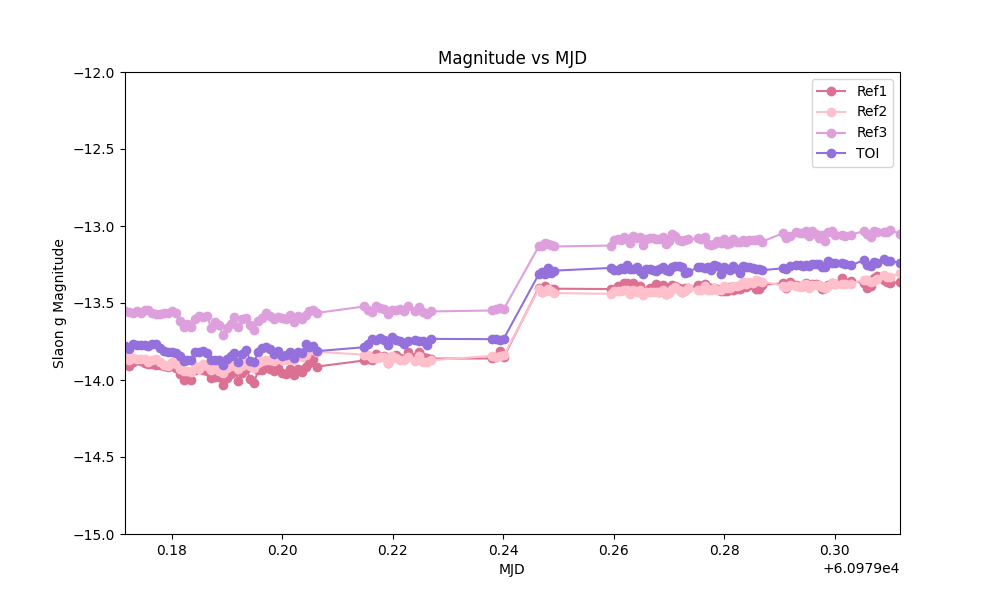

In [55]:
# plot magnitude vs mjd for each target
plt.figure(figsize=(10, 6))
colors = ["palevioletred", "pink", "plum", "mediumpurple"]
names = ["Ref1", "Ref2", "Ref3", "TOI"]
mag_files = [ref1_mags, ref2_mags, ref3_mags, toi_mags]
for i, mags in enumerate(mag_files):
    plt.plot(mjds, mags, marker='o', linestyle='-', color=colors[i], label=f"{names[i]}")
plt.xlabel('MJD')
plt.ylabel('Slaon g Magnitude')
plt.title('Magnitude vs MJD')
plt.legend()
plt.xlim(mjds[reasonable_xmin], mjds[reasonable_xmax])
plt.ylim(-15, -12)

(-15.0, -12.0)

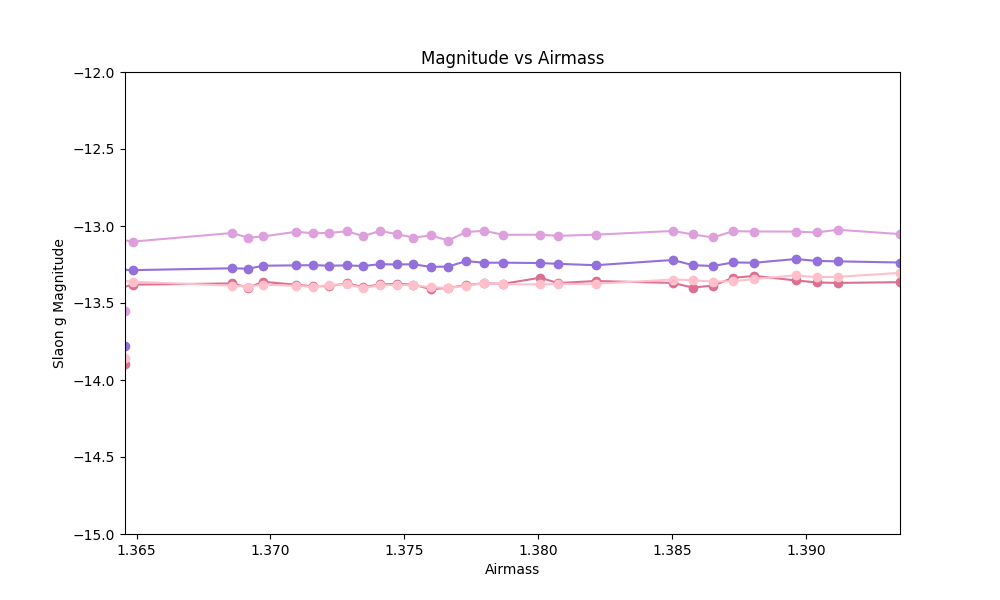

In [50]:
# plot magnitude versus airmass for each target
airmass = []
for i in range(len(toi_fnames_final)):
    with fits.open(toi_fnames_final[i]) as hdul:
        hdr = hdul[0].header
        airmass_value = hdr.get("AIRMASS", None)
        airmass.append(airmass_value)

plt.figure(figsize=(10, 6))
colors = ["palevioletred", "pink", "plum", "mediumpurple"]
names = ["Ref1", "Ref2", "Ref3", "TOI"]
mag_files = [ref1_mags, ref2_mags, ref3_mags, toi_mags]
for i, mags in enumerate(mag_files):
    plt.plot(airmass, mags, marker='o', linestyle='-', color=colors[i], label=f"{names[i]}")
plt.xlabel('Airmass')
plt.ylabel('Slaon g Magnitude')
plt.title('Magnitude vs Airmass')
plt.legend
plt.xlim(airmass[reasonable_xmin], airmass[reasonable_xmax])
plt.ylim(-15, -12)

instrumental magnitudes: just convert the raw flux to a magnitude. m = -2.5log_10(raw flux)

when making the light curves, when normalizing by the fluxes of the reference stars, normalize by the MEDIAN of the fluxes of the reference stars, to mitigate any outliers in flux. 